# Loads

Loads are calculated via the `loads` method of `SimulationResult`. It requires a `WindTurbine` object where the `loadFunction` input argument is set.

The loadFunction is typically wrapping a surrogate model, e.g. a [Tensorflow surrogate model](#Tensorflow-surrogate-model).

Currently, two load surrogate approaches are supported:

- One wind turbine surrogate: Surrogate representation of loads of a wind turbine in different inflow conditions, e.g. wind speed, turbulence intensity, shear, etc.
- Two wind turbine surrogate: Surrogate representation of loads of a wind turbine in different wake and inflow conditions

The `loads` function calculcate the 

- DEL: Damage equivalent load
- LDEL: Life-time damage equivalent load

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
from py_wake.examples.data.iea34_130rwt._iea34_130rwt import IEA34_130_1WT_Surrogate
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.turbulence_models import CrespoHernandez
from py_wake import ZongGaussian
from IPython.display import display, Markdown

wt = IEA34_130_1WT_Surrogate()
site = Hornsrev1Site()
wfm = ZongGaussian(site, wt, turbulenceModel=CrespoHernandez())
sim_res = wfm([0], [0])
sim_res.loads()

<xarray.Dataset>
Dimensions:  (sensor: 5, wd: 360, ws: 23, wt: 1)
Coordinates:
  * sensor   (sensor) <U21 'del_blade_flap' ... 'del_tower_top_torsion'
    m        (sensor) int32 10 10 4 4 7
  * wt       (wt) int32 0
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
Data variables:
    DEL      (sensor, wt, wd, ws) float64 4.113e+03 754.1 ... 5.14e+03 5.353e+03
    P        (wd, ws) float64 6.147e-05 8.559e-05 ... 5.738e-08 2.193e-08
    LDEL     (sensor, wt) float64 5.367e+03 8.412e+03 ... 1.898e+04 5.112e+03

## Tensorflow surrogate model

`TensorflowSurrogate` needs a TensorFlow model and a json file describing the inputs, outputs, scaling and wöhler exponent 

Furthermore, it needs a function that links a set of PyWake data variables to the surrogate input (in correct order and units). See example functions below (one and two wind turbine approach):

In [3]:
# One WT
def get_input(ws, TI_eff, yaw=0, Alpha=0): # PyWake data variables
    # ['ws', 'ti', 'shear'] Surrogate input
    return [ws,
            TI_eff * 100,  # surrogate is in %, pywake is in decimal
            Alpha,
            np.degrees(yaw)]  # surrogate is in deg, pywake-windturbines is in radians


In [4]:
# Two WT
MAX_DIST = 50 # D
MAX_ANGLE = 45 # deg
def get_input(ws, TI, dw_ijlk, hcw_ijlk, Alpha=0):
    # output: ['ti', 'ws', 'shear', 'wdir', 'dist']
    dist = np.hypot(dw_ijl, hcw_ijl) / 130
    wd = np.rad2deg(np.arctan2(hcw_ijl, dw_ijl))
    unwaked = (dist== 0) | (dist>MAX_DIST) | (np.abs(wd) > MAX_ANGLE)
    dist[unwaked] = MAX_DIST
    wd[unwaked] = 45
    return [TI, ws, Alpha, wd, dist]

## One wind turbine approach (effective turbulence)

The one-wind-turbine approach typically estimates the loads based on an effective turbulence intensity measure.

With a one-wind-turbine surrogate, the argument `average_ti` argument to `simulationResult.loads` switches between top options:

- `average_ti=False`: DEL loads are calculated for all wind directions, i.e. a load value per sensor, wind turbine, wind direction and wind speed
- `average_ti=True`: The loads are calculated based on an omni-directional mean turbulence intensity, i.e. one load value per sensor, wind turbine and wind speed, as described in IEC61400-1, 2017, Annex E.

## Two wind turbine appraoch 

In the two wind-turbine approach, the surrogate contains loads of a wind turbine in different wake and inflow conditions.

The idea is to split the wind farm into pairs of wind turbines and return the load of the pair that yields the highest load.

### Max functions

To calculate the highest load among wind turbine pairs three max-functions have been implemented

In [5]:
# setup plot function used below
import numpy as np
from numpy import newaxis as na
import matplotlib.pyplot as plt
from py_wake.utils.max_functions import StrictMax, SoftMax, SmoothMax
f = 1000
a = np.arange(1, 2.01, .01) * f
b = a[::-1]
A_siilk = np.array([a, b])[na, :, :, na, na]
def plot_max(max_function_lst):
    plt.plot(A_siilk[0, 0, :, 0, 0], '-', label='A')
    plt.plot(A_siilk[0, 1, :, 0, 0], '-', label='B')
    for max_function in max_function_lst:
        plt.plot(max_function(A_siilk)[0,:,0,0], '--', label=str(max_function))
    plt.legend()

#### StrictMax
Normal maximum function. Gives exact results but the gradients are not continous and therefore not suited for optimization

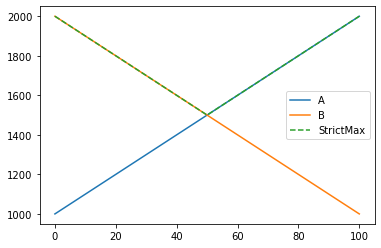

In [6]:
plot_max([StrictMax()])

#### SoftMax (LogSumExp)

The softmax function ensures a smooth transition (nice gradient) but overpredicts the maximum when the inputs have similar values.

SoftMax takes a `base` argument, which determines the amount of smoothness

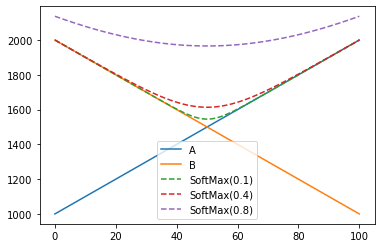

In [7]:
plot_max([SoftMax(.1), SoftMax(0.4),SoftMax(0.8)])

#### SmoothMax

SmoothMax is also smooth and it gives the right value when the imput values are equal, but underpredicts the max when they are not exactly equal.

SmoothMax takes a `base` argument, which determines the amount of smoothness

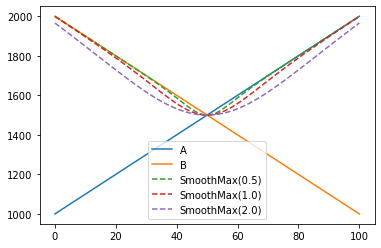

In [8]:
plot_max([SmoothMax(.5),SmoothMax(1), SmoothMax(2)])

## Validation

The validation is performed by comparing the surrogate output to the loads computed by HAWC2 in a simulation with:

| | |
 -- | -- 
Wind speed | 10m/s
Turbulence intensity | 10%
Shear |  0


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList, PowerCtTabular
from py_wake.examples.data.iea34_130rwt import IEA34_130_1WT_Surrogate, IEA34_130_2WT_Surrogate, \
        IEA34_130_DeficitModel, IEA34_130_TurbulenceModel
from py_wake.superposition_models import LinearSum, MaxSum, SqrMaxSum
from py_wake.turbulence_models import CrespoHernandez
from py_wake import ZongGaussian
from pathlib import Path
from py_wake.examples.data import example_data_path
from py_wake.flow_map import XYGrid
from numpy import newaxis as na
from scipy.optimize._minimize import minimize


p = Path(example_data_path) / 'iea34_130rwt'

one_wt = IEA34_130_1WT_Surrogate()
two_wt_ws_uw = IEA34_130_2WT_Surrogate('uw')
two_wt_ws_uw_eff = IEA34_130_2WT_Surrogate('uw_eff')
two_wt_ws_dw_eff = IEA34_130_2WT_Surrogate('dw_eff')


for wt in [one_wt, two_wt_ws_uw, two_wt_ws_uw_eff, two_wt_ws_dw_eff]:
    wt.powerCtFunction = PowerCtFunctionList(
        key='operating',
        powerCtFunction_lst=[PowerCtTabular(ws=[0, 100], power=[0, 0], power_unit='w', ct=[0, 0]),  # 0=No power and ct
                             wt.powerCtFunction],  # 1=Normal operation
        default_value=1)
    
site = Hornsrev1Site()

wfm_one_wt, wfm_ws_uw, wfm_ws_uw_eff, wfm_ws_dw_eff = [
    PropagateDownwind(site, wt, wake_deficitModel=IEA34_130_DeficitModel(inflow_input='uw', shear_alpha=0),
                      turbulenceModel=IEA34_130_TurbulenceModel(inflow_input='uw', shear_alpha=0,
                                                                addedTurbulenceSuperpositionModel=MaxSum())) 
              for wt in [one_wt, two_wt_ws_uw, two_wt_ws_uw_eff, two_wt_ws_dw_eff]]
name_wohler = [('del_blade_flap', 10), 
               ('del_blade_edge', 10),
               ('del_tower_bottom_fa', 4 ),
               ('del_tower_bottom_ss', 4),
               ('del_tower_top_torsion' ,7)] 

sensor_names = {'del_blade_flap':'flap',
                'del_blade_edge':'edge',
                'del_tower_bottom_fa': 'tb_fa',
                'del_tower_bottom_ss': 'tb_ss',
                'del_tower_top_torsion': 'tt_z'}

### One WT (unwaked)

sensor | wohler | HAWC2 | IEA34_130_1WT_Surrogate | IEA34_130_2WT_Surrogate
-- | -- |-- | -- | --
del_blade_flap | 10 | 2900 |2899 | 2990
del_blade_edge | 10 | 5733 | 5742 | 5750
del_tower_bottom_fa | 4 | 8458 | 8032 | 8184
del_tower_bottom_ss | 4 | 3325 | 3292 | 3146
del_tower_top_torsion | 7 | 2238 | 2269 | 2285

Text(0, 0.5, 'TwoWT Surrogate')

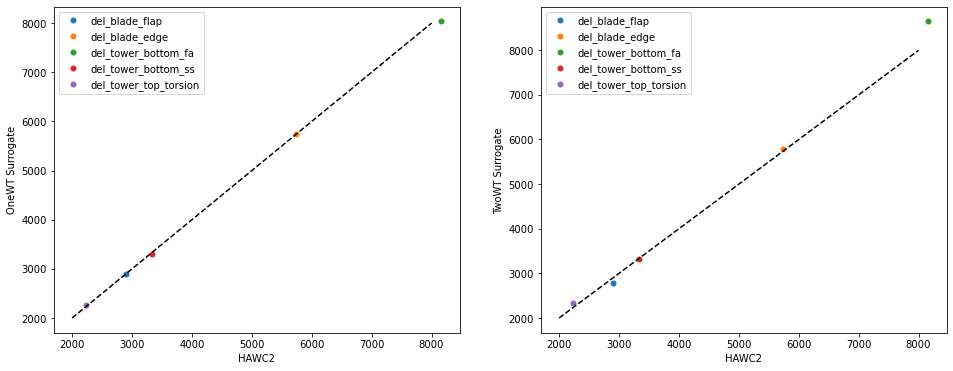

In [10]:
one_wt_hawc2_loads = [2900, 5733, 8158, 3325, 2238]

def plot_loads(del_loads, ax):
    for r, l in zip(one_wt_hawc2_loads, del_loads):
        ax.plot(r, l.item(),'.',ms=10, label=l.sensor.item())
        # print ("%s %d (%+.1f%%)"%(sensor_names[l.sensor.item()], l.item(), (l.item()-r)/r*100))
    ax.plot([2000,8000],[2000,8000],'k--')
    ax.set_xlabel('HAWC2')
    
    ax.legend()

ax1, ax2 = plt.subplots(1,2, figsize=(16,6))[1]
plot_loads(wfm_one_wt([0],[0], wd=270,ws=10,TI=0.1).loads().DEL, ax1)
ax1.set_ylabel('OneWT Surrogate')
plot_loads(wfm_ws_uw([0],[0], wd=270,ws=10,TI=0.1).loads().DEL, ax2)
ax2.set_ylabel('TwoWT Surrogate')

### Two WT

In [11]:
# loads from 6 cases, 15 simulations per case and 5 sensors
two_wt_hawc2_loads = np.array([
# a1
[[  3098,   5568,   8272,   3547,   2906], [  3415,   5580,   8229,   3201,   2773],
 [  3459,   5709,   9956,   4252,   3079], [  3257,   5700,   8902,   3126,   2660],
 [  3080,   5636,   8215,   3073,   2892], [  3142,   5587,   8523,   3220,   2755],
 [  3052,   5688,   8336,   3289,   2803], [  3095,   5612,   9794,   3381,   2751],
 [  3195,   5580,   9256,   3390,   2706], [  3187,   5653,   8330,   2859,   2716],
 [  3516,   5563,  10674,   3279,   2632], [  3644,   5503,  10002,   4454,   3036],
 [  3139,   5606,   8563,   3302,   2802], [  2926,   5587,   8798,   2985,   2559],
 [  3342,   5744,   9759,   3532,   3220]],
# a2
[[  3419,   5631,   7784,   3146,   3253], [  3751,   5618,   8501,   3367,   3223],
 [  4218,   5576,  12694,   9139,   3640], [  3209,   5750,   9033,   4194,   3081],
 [  3202,   5681,   8060,   3684,   3158], [  3397,   5625,   8309,   3536,   3390],
 [  3238,   5720,   8675,   3056,   3141], [  3281,   5628,   8821,   3397,   3335],
 [  3374,   5607,   9354,   4269,   3199], [  3407,   5692,   8039,   2747,   2908],
 [  4068,   5562,   8916,   3645,   3349], [  4039,   5549,   8969,   3353,   3397],
 [  3315,   5673,   8563,   3402,   3243], [  3190,   5619,   8743,   3342,   3186],
 [  3713,   5716,  10429,   4065,   3288]],
# b1
[[  4205,   5365,  14479,   5079,   2908], [  3699,   5344,  10498,   3230,   2677],
 [  3923,   5602,  11526,   3818,   3474], [  3807,   5463,  12623,   6157,   3168],
 [  3960,   5319,  13155,   3747,   2714], [  3848,   5394,  12037,   4682,   2951],
 [  3306,   5419,  11387,   3477,   2675], [  3638,   5556,  12746,   5441,   2877],
 [  3926,   5540,  12415,   3482,   3476], [  3879,   5459,  12086,   4448,   2914],
 [  3769,   5516,  11694,   3389,   3151], [  4065,   5294,  15538,   6176,   2619],
 [  3708,   5386,  11705,   4156,   2685], [  3544,   5428,  11596,   3605,   2865],
 [  3854,   5660,  13055,   3613,   3093]],
# b2
[[  4795,   4992,  18375,   5382,   3292], [  4760,   5016,  13493,   5457,   3438],
 [  5027,   5390,  16424,   5595,   4343], [  4524,   5146,  15549,   6116,   3225],
 [  4550,   4975,  18531,   7424,   3128], [  4876,   5080,  15632,   4405,   3599],
 [  4232,   5049,  14676,   5185,   3188], [  4447,   5227,  17551,   5590,   3256],
 [  4803,   5123,  16673,   6083,   3713], [  4463,   5131,  15127,   6774,   3601],
 [  4958,   5182,  18356,   5800,   3699], [  5037,   4974,  18530,   5886,   3680],
 [  4762,   5017,  15385,   5075,   3173], [  4704,   5062,  14031,   4587,   3380],
 [  4478,   5334,  17482,   7386,   3886]],
# c1
[[  4197,   5646,  14165,   5525,   3233], [  4066,   5650,  12596,   4915,   3283],
 [  4077,   5651,  13101,   4148,   3823], [  3935,   5810,  15253,   5207,   3504],
 [  3291,   5596,  13338,   5544,   2577], [  3849,   5676,  14499,   5055,   2973],
 [  3307,   5664,  13566,   6453,   2675], [  3928,   5867,  12732,   4296,   3532],
 [  4531,   5803,  15638,   5771,   4072], [  3867,   5779,  12052,   4872,   3195],
 [  4339,   5712,  13817,   4803,   3248], [  3750,   5573,  14339,   4176,   3210],
 [  3829,   5721,  13128,   5049,   3275], [  4260,   5746,  13695,   3718,   4012],
 [  4108,   5797,  15017,   3672,   3407]],
# c2
[[  3302,   5434,  23708,  18043,   2756], [  3663,   5440,  18020,  15044,   2209],
 [  4157,   5541,  18831,   7443,   3847], [  3457,   5510,  19768,  10333,   2398],
 [  2508,   5380,  19483,  11074,   2124], [  2878,   5475,  17326,   8682,   2469],
 [  2678,   5478,  22098,  11114,   2109], [  4718,   5665,  19596,  10574,   3704],
 [  3956,   5699,  18571,  18021,   3491], [  3184,   5536,  17742,   9367,   2830],
 [  4525,   5538,  19846,   9175,   3204], [  2753,   5366,  21143,  17874,   2267],
 [  2710,   5470,  21533,  10315,   2480], [  3202,   5505,  18640,   9330,   2892],
 [  4140,   5694,  21242,   9255,   3641]],
# d1
[[  3938,   5975,  11684,   4256,   2786], [  4268,   6091,  11262,   3818,   3159],
 [  3928,   5802,  13300,   4477,   3014], [  4424,   6075,  15108,   3746,   2959],
 [  4415,   6112,  11880,   4117,   2712], [  4158,   5991,  13132,   6075,   3086],
 [  4236,   6115,  12301,   5041,   2900], [  4015,   5956,  12638,   3984,   3662],
 [  4139,   5824,  14295,   4938,   2890], [  4025,   5948,  12808,   4513,   2965],
 [  4314,   5800,  12101,   4301,   3436], [  4092,   6033,  11054,   3339,   3310],
 [  4378,   6130,  11815,   4164,   2764], [  3916,   5999,  12122,   5445,   3007],
 [  3978,   5937,  14354,   5744,   3029]],
# d2
[[  4874,   6256,  16924,   4645,   3342], [  5018,   6367,  16025,   4764,   3156],
 [  5109,   6110,  22108,  16577,   3042], [  5436,   6417,  22283,   6475,   3727],
 [  4931,   6346,  17001,   6438,   2987], [  4987,   6341,  16088,   4127,   3582],
 [  4984,   6366,  16763,   4205,   3294], [  5027,   6300,  20145,   5052,   3774],
 [  5035,   6168,  19409,   7718,   3299], [  4833,   6278,  18017,   5512,   3440],
 [  5031,   6154,  18749,   6881,   3647], [  4883,   6300,  15508,   4638,   3465],
 [  5445,   6422,  15503,   5319,   3374], [  5076,   6336,  16923,   7520,   3598],
 [  5000,   6225,  20464,   6021,   3202]],
# e1
[[  3437,   5931,   7489,   3810,   2963], [  3162,   5827,   8595,   3020,   2569],
 [  4282,   5838,  11699,   3810,   3075], [  3775,   5991,   8870,   3323,   2828],
 [  3503,   5911,   7940,   2843,   2810], [  3810,   5865,   9988,   3245,   2716],
 [  3508,   5954,   9505,   3137,   2646], [  3641,   5877,  10496,   2991,   3126],
 [  3600,   5853,  10360,   3765,   2673], [  3724,   5885,  10586,   4072,   2726],
 [  4062,   5845,  11591,   3901,   3099], [  3219,   5823,   8442,   3499,   2863],
 [  3136,   5868,   8250,   3146,   2517], [  3364,   5852,   9051,   3842,   2522],
 [  4094,   5975,  10776,   4495,   2577]],
# e2
[[  3511,   5848,   8143,   3981,   2973], [  3171,   5771,   8839,   3239,   2671],
 [  4534,   5897,  16255,   4044,   3628], [  4098,   5939,   9393,   3615,   3204],
 [  3635,   5845,   8606,   3247,   3124], [  4189,   5845,  10519,   3891,   3251],
 [  3659,   5903,   9443,   2835,   2663], [  4293,   5958,  10950,   3444,   3628],
 [  4181,   5892,  11093,   4017,   3389], [  4202,   5948,   9922,   3978,   3514],
 [  4681,   5934,  10987,   4387,   3702], [  3351,   5757,   8791,   3385,   3008],
 [  3125,   5810,   8781,   3722,   2548], [  3403,   5856,   9215,   5051,   2777],
 [  4523,   6082,   9672,   3511,   3494]]])
two_wt_cases = [f"{abc}{i}" for abc in 'ABCDE' for i in [1,2]]
two_wt_pos = {c:(x,y) for c,y,x in [('A1',-130,-780),('A2',-130,-390),('B1',-65,-780),('B2',-65,-390),
                                    ('C1',0,-780),('C2',0,-390),('D1',65,-780),('D2',65,-390),
                                    ('E1',130,-780),('E2',130,-390)]}

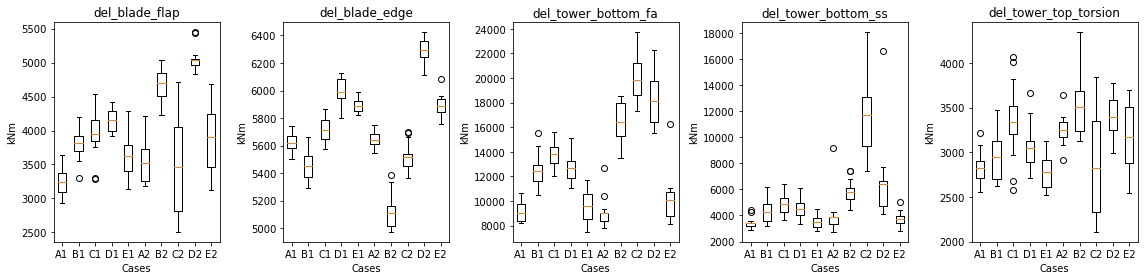

In [12]:
axes = plt.subplots(1,5, figsize=(16,4))[1].flatten()
m =[0,2,4,6,8,1,3,5,7,9]
for i, (ax, (sensor,w)) in enumerate(zip(axes, name_wohler)):
    ax.boxplot(two_wt_hawc2_loads[m,:,i].T, usermedians=two_wt_hawc2_loads[m,:,i].mean(1))
    ax.set_xticklabels(np.array(two_wt_cases)[m])
    ax.set_title(sensor)
    ax.set_ylabel('kNm')
    ax.set_xlabel('Cases')
plt.tight_layout()    

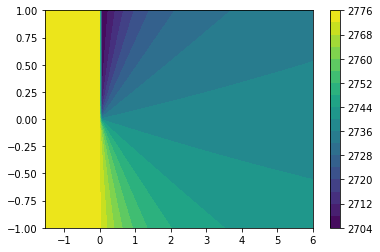

In [13]:
X,Y = np.meshgrid(np.linspace(-200,780,100), np.linspace(-130,130,100))
sensor = 0
Z = two_wt_ws_uw.loadFunction(np.zeros(10000)+10, dw_ijlk=X.flatten(), hcw_ijlk=Y.flatten(), TI=np.zeros(10000)+.1)[sensor].reshape(X.shape)
c = plt.contourf(X/130,Y/130,Z,20)
plt.colorbar(c)

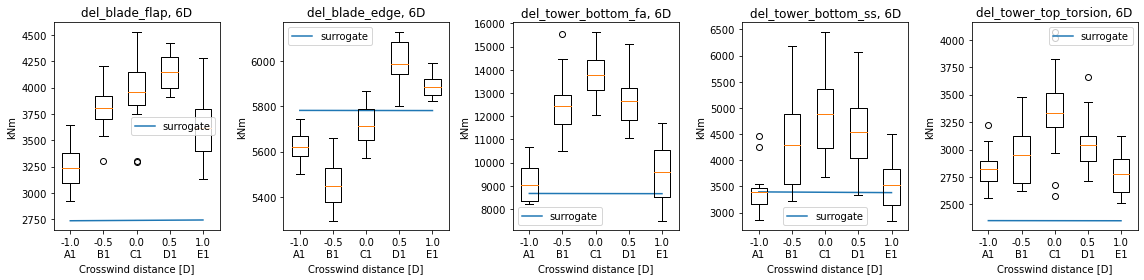

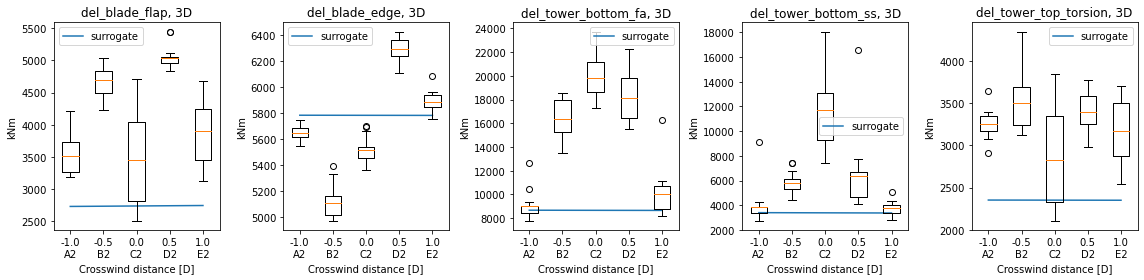

In [14]:
for d_i, dw in enumerate([6,3]):
    axes = plt.subplots(1,5, figsize=(16,4))[1].flatten()
    
    for s_i, (ax, (sensor,w)) in enumerate(zip(axes, name_wohler)):
        N = 10
        two_wt_ws_uw = IEA34_130_2WT_Surrogate('uw', max_function=StrictMax())
        loads = two_wt_ws_uw.loadFunction(ws=np.full(N,10), dw_ijlk=[dw*130]*N, hcw_ijlk=np.linspace(130,-130,N), TI=[0.1]*N)[s_i]
        ax.plot(np.linspace(1,5,N), loads, label='surrogate')
        ax.boxplot(two_wt_hawc2_loads[d_i::2,:,s_i].T, usermedians=two_wt_hawc2_loads[d_i::2,:,s_i].mean(1))
        
        #ax.set_xticklabels()
        ax.set_xticklabels(["%.1f\n%s"%(hcw,c) for hcw, c in zip(np.linspace(-1,1,5),two_wt_cases[d_i::2])])
        ax.set_title(f"{sensor}, {dw}D")
        ax.set_ylabel('kNm')
        ax.set_xlabel('Crosswind distance [D]')
        ax.legend()
    plt.tight_layout()    
 

**HAWC2 mean loads**

In [14]:
# print table
from IPython.display import display, Markdown, Latex
table = ["sensor | wohler | " + '|'.join(two_wt_cases), 
         "|".join([' -- ']*12)]
for (s,w), l in zip(name_wohler, np.round(two_wt_hawc2_loads.mean(1)).astype(int).T):
    table +=[f"{s} | {w} | {'|'.join(map(str,l))}"]
display(Markdown("\n".join(table)))

sensor | wohler | A1|A2|B1|B2|C1|C2|D1|D2|E1|E2
 -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 3236|3521|3809|4694|3956|3455|4148|5045|3621|3904
del_blade_edge | 10 | 5621|5643|5450|5113|5713|5515|5986|6292|5886|5886
del_tower_bottom_fa | 4 | 9041|8993|12436|16388|13796|19836|12657|18127|9576|10041
del_tower_bottom_ss | 4 | 3393|3889|4300|5783|4880|11710|4531|6393|3527|3756
del_tower_top_torsion | 7 | 2819|3253|2950|3507|3335|2828|3045|3395|2781|3172

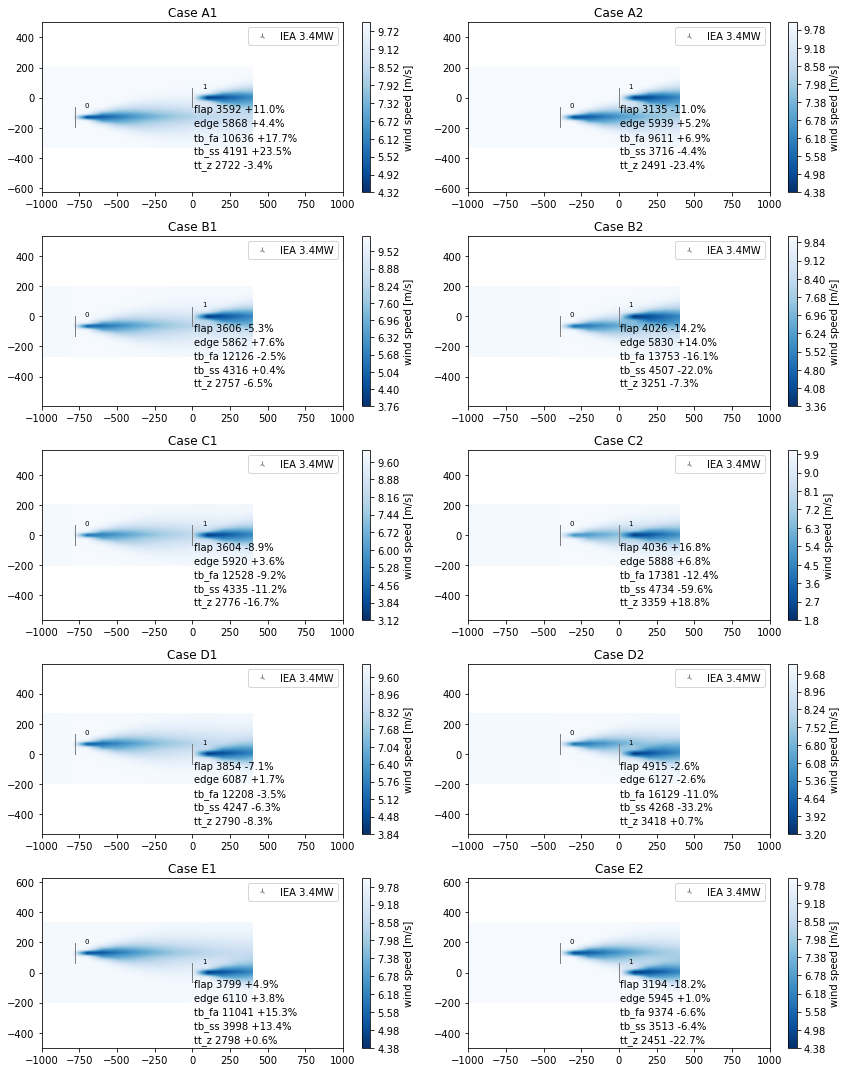

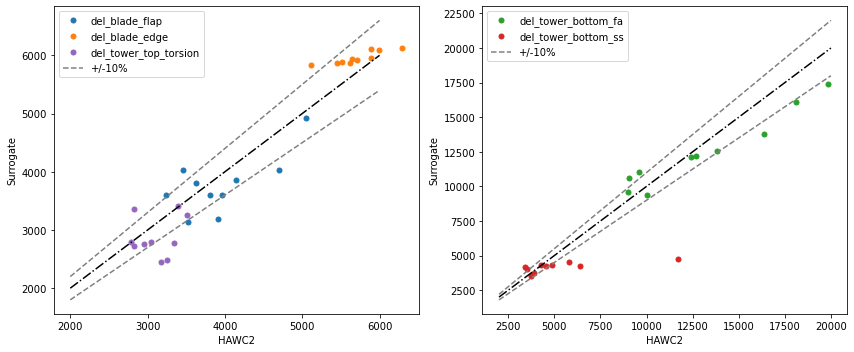

In [15]:
ref_loads = np.round(two_wt_hawc2_loads.mean(1)).astype(int).T

fig1, axes = plt.subplots(5,2,figsize=(12,15))
dot_axes = plt.subplots(1,2, figsize=(12,5))[1].flatten()

for case_i, (ax, case) in enumerate(zip(axes.flatten(), two_wt_cases)):
    wt_up = two_wt_pos[case]
    sim_res = wfm_ws_uw([wt_up[0],0],[wt_up[1],0], wd=270,ws=10,TI=0.1)
    sim_res.flow_map(XYGrid(x=np.arange(-1000,500,100),resolution=100)).plot_wake_map(ax=ax)
    ax.set_xlim([-1000,1000])
    ax.set_title(f'Case {case}')
    
    for i, (r, l) in enumerate(zip(ref_loads[:,case_i], sim_res.loads().DEL.isel(wt=-1))):
        #print (r, l.item())
        c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][i]
        ax.annotate("%s %d %+.1f%%"%(sensor_names[l.sensor.item()], l.item(), (l.item()-r)/r*100),(10,-100-i*90))
        d_ax = dot_axes[int(i in [2,3])]    
        d_ax.plot(r, l.item(),'.',color=c, ms=10, label=(l.sensor.item(), '')[case_i>0])
        
        
for ax, lim in zip(dot_axes,[6000,20000]):
    ax.plot([2000,lim],[2000,lim],'k-.')
    ax.plot([2000,lim],[2000*.9,lim*.9],'--', color='gray')
    ax.plot([2000,lim],[2000*1.1,lim*1.1],'--', color='gray', label='+/-10%')
    ax.set_xlabel('HAWC2')
    ax.set_ylabel('Surrogate')
    ax.legend()
fig1.tight_layout()
plt.tight_layout()

### Three WT

In [16]:
three_wt_hawc2_loads = np.array([
# three_wt_case_a
[[  2733,   5713,   7662,   3939,   2197], [  2906,   5689,   8332,   3541,   2154],
 [  3167,   5713,   8404,   3634,   2498], [  3670,   6132,  10404,   3734,   2422],
 [  2822,   6065,   8606,   3136,   2515], [  2684,   5709,   7900,   3738,   2205],
 [  3053,   5804,   8529,   3067,   2260], [  2702,   5751,   8242,   2782,   2176],
 [  2864,   5685,   8292,   4131,   2366], [  3346,   6045,   9735,   3371,   2466],
 [  2875,   5695,   7952,   2630,   2098], [  2738,   5664,   7974,   3308,   2517],
 [  3154,   6029,   9866,   3893,   2430], [  2808,   5723,   8210,   3476,   2064],
 [  3003,   6098,   9436,   3112,   2171]],
# three_wt_case_b
[[ 2733,  5713,  7662,  3939,  2197], [ 3094,  6048,  9750,  4018,  2379],
 [ 3373,  6011,  9676,  4109,  2711], [ 3331,  5816,  8834,  3326,  2261],
 [ 2852,  6065,  8570,  3138,  2516], [ 2925,  6023,  9238,  4168,  2405],
 [ 3053,  5804,  8529,  3067,  2260], [ 2702,  5751,  8242,  2782,  2176],
 [ 2864,  5685,  8292,  4131,  2366], [ 3136,  5754,  8091,  2897,  2281],
 [ 2875,  5695,  7952,  2630,  2098], [ 2738,  5664,  7974,  3308,  2517],
 [ 2983,  5728,  8387,  3735,  2198], [ 2808,  5723,  8210,  3476,  2064],
 [ 2855,  5796,  8112,  2763,  2011]],
# three_wt_case_c
[[ 2733,  5713,  7662,  3939,  2197], [ 3104,  5995,  9396,  3886,  2391],
 [ 3373,  6011,  9676,  4109,  2711], [ 3331,  5816,  8834,  3326,  2261],
 [ 2660,  5757,  7443,  2909,  2283], [ 2925,  6023,  9238,  4168,  2405],
 [ 3053,  5804,  8529,  3067,  2260], [ 2935,  6065,  9743,  3152,  2350],
 [ 3022,  5989,  9479,  4705,  2541], [ 3346,  6045,  9735,  3371,  2466],
 [ 3061,  6002,  9355,  3010,  2274], [ 2738,  5664,  7974,  3308,  2517],
 [ 2983,  5728,  8387,  3735,  2198], [ 2999,  6031,  9318,  3841,  2187],
 [ 2968,  6099,  9420,  3110,  2142]],
# three_wt_case_d
[[  2829,   6007,   8923,   4123,   2399], [  3104,   5995,   9396,   3886,   2391],
 [  3167,   5713,   8404,   3634,   2498], [  3331,   5816,   8834,   3326,   2261],
 [  2828,   6062,   8580,   3147,   2537], [  2925,   6023,   9238,   4168,   2405],
 [  3304,   6171,  10021,   3518,   2481], [  2907,   6061,   9590,   3148,   2341],
 [  2864,   5685,   8292,   4131,   2366], [  3346,   6045,   9735,   3371,   2466],
 [  3064,   6004,   9234,   3013,   2278], [  2738,   5664,   7974,   3308,   2517],
 [  3154,   6029,   9866,   3893,   2430], [  2808,   5723,   8210,   3476,   2064],
 [  2855,   5796,   8112,   2763,   2011]],
# three_wt_case_e
[[ 2733,  5713,  7662,  3939,  2197], [ 2906,  5689,  8332,  3541,  2154],
 [ 3167,  5713,  8404,  3634,  2498], [ 3331,  5816,  8834,  3326,  2261],
 [ 2660,  5757,  7443,  2909,  2283], [ 2684,  5709,  7900,  3738,  2205],
 [ 3053,  5804,  8529,  3067,  2260], [ 2702,  5751,  8242,  2782,  2176],
 [ 2864,  5685,  8292,  4131,  2366], [ 3136,  5754,  8091,  2897,  2281],
 [ 2875,  5695,  7952,  2630,  2098], [ 2738,  5664,  7974,  3308,  2517],
 [ 2983,  5728,  8387,  3735,  2198], [ 2808,  5723,  8210,  3476,  2064],
 [ 2855,  5796,  8112,  2763,  2011]],
# three_wt_case_f
[[ 2733,  5713,  7662,  3939,  2197], [ 2906,  5689,  8332,  3541,  2154],
 [ 3167,  5713,  8404,  3634,  2498], [ 3331,  5816,  8834,  3326,  2261],
 [ 2660,  5757,  7443,  2909,  2283], [ 2684,  5709,  7900,  3738,  2205],
 [ 3053,  5804,  8529,  3067,  2260], [ 2702,  5751,  8242,  2782,  2176],
 [ 2864,  5685,  8292,  4131,  2366], [ 3136,  5754,  8091,  2897,  2281],
 [ 2875,  5695,  7952,  2630,  2098], [ 2738,  5664,  7974,  3308,  2517],
 [ 2983,  5728,  8387,  3735,  2198], [ 2808,  5723,  8210,  3476,  2064],
 [ 2855,  5796,  8112,  2763,  2011]]])
three_wt_cases = 'ABCDEF'
three_wt_pos = {c:(y1,y2) for c,y1,y2 in [('A',0,0),('B',130,0),('C',0,130),
                                          ('D',130,130),('E',0,-130),('F',-130,-130)]}

HAWC2 mean loads

In [17]:
# print table
from IPython.display import display, Markdown, Latex
table = ["sensor | wohler | " + '|'.join(three_wt_cases), 
         "|".join([' -- ']*8)]
for (s,w), l in zip(name_wohler, np.round(three_wt_hawc2_loads.mean(1)).astype(int).T):
    table +=[f"{s} | {w} | {'|'.join(map(str,l))}"]
display(Markdown("\n".join(table)))

sensor | wohler | A|B|C|D|E|F
 -- | -- | -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 2968|2955|3015|3015|2900|2900
del_blade_edge | 10 | 5834|5818|5916|5920|5733|5733
del_tower_bottom_fa | 4 | 8636|8501|8946|8961|8158|8158
del_tower_bottom_ss | 4 | 3433|3432|3576|3527|3325|3325
del_tower_top_torsion | 7 | 2303|2296|2346|2363|2238|2238

In [18]:
def plot_case(case):
    case_i = three_wt_cases.index(case)
    y = [three_wt_pos[case][0],three_wt_pos[case][1],0]
    ref_loads = (np.round(three_wt_hawc2_loads[case_i].mean(0)).astype(int))
    x, y = np.asarray([0, 3, 6]) * 130, np.asarray(y) 
    wd = 270
    
    sim_res_3wt_uw = wfm_ws_uw(x, y, ws=10, wd=wd, operating=[1, 1, 1])
    sim_res_3wt_uw_eff = wfm_ws_uw_eff(x, y, ws=10, wd=wd, operating=[1, 1, 1])
    sim_res_3wt_dw_eff = wfm_ws_dw_eff(x, y, ws=10, wd=wd, operating=[1, 1, 1])
    plt.figure(figsize=(6,3))
    plt.gca().set_title('Three WT')
    
    
    def plot_subcase(sim_res, loads, ax=plt.gca()):
        fm = sim_res.flow_map(XYGrid(x=np.linspace(-200, 1000, 200), y=np.linspace(-200, 330, 200)))
        fm.plot_wake_map(ax=ax, levels=np.linspace(0, 10, 100), plot_colorbar=False)
        for x, y, ws, ti in zip(sim_res.x, sim_res.y,
                                sim_res.WS_eff.values, sim_res.TI_eff):
            _ = ax.annotate(f'{ws.item():.2f}m/s', (x + 10, y))
            _ = ax.annotate('%d%%' % (ti * 100), (x + 10, y - 55))
        _ = ax.annotate('%dkNm' % np.round(loads[0]), (sim_res.x[-1] + 10, sim_res.y[-1] - 110))
        #ax.figure.tight_layout()
    
    plot_subcase(sim_res_3wt_dw_eff, ref_loads)
    loads_lst = [ref_loads]
    

    # WS_UP
    axes = plt.subplots(1, 3, figsize=(16, 3))[1]
    loads_ds = sim_res_3wt_uw.loads().DEL.isel(wt=2).squeeze()
    loads_lst.append(loads_ds.values)
    
    plt.suptitle('Amb. WS and TI of upstream WT')
    for ax, op in zip(axes, [[1, 0, 1], [0, 1, 1], [0, 0, 1]]):
        sim_res = wfm_ws_uw(x[np.array(op, bool)], y[np.array(op, bool)], ws=10, TI=.1, wd=wd)
        load = two_wt_ws_uw.loads(ws=np.array([10]), dw_ijlk=np.diff(np.r_[sim_res.x, 780])[0],
                              hcw_ijlk=np.diff(np.r_[sim_res.y, 0])[0], TI=np.array([.1]))
        _ = plot_subcase(sim_res, np.round(load)[:,0], ax=ax)
    
      
    # WS_UP_eff
    axes = plt.subplots(1, 3, figsize=(16, 3))[1]
    plt.suptitle('WS_eff and TI_eff of upstream WT')
    loads_lst.append(sim_res_3wt_uw.loads().DEL.isel(wt=2).squeeze().values)
    for ax, op in zip(axes, [[1, 0, 1], [0, 1, 1], [0, 0, 1]]):
        ws = sim_res_3wt_uw_eff.WS_eff.sel(wt=np.where(op)[0]).isel(wt=0).item()
        ti = sim_res_3wt_uw_eff.TI_eff.sel(wt=np.where(op)[0]).isel(wt=0).item()
        sim_res = wfm_ws_uw_eff(x[np.array(op, bool)], y[np.array(op, bool)], ws=ws, TI=ti, wd=wd)
        load = two_wt_ws_uw.loads(ws=np.array([ws]), dw_ijlk=np.diff(np.r_[sim_res.x, 780])[0],
                              hcw_ijlk=np.diff(np.r_[sim_res.y, 0])[0], TI=np.array([ti]))
        _ = plot_subcase(sim_res, load, ax=ax)

    
    # WS_DW_eff
    axes = plt.subplots(1, 3, figsize=(16, 3))[1]
    plt.suptitle('WS_eff and TI_eff of downstream WT')
    loads_lst.append(sim_res_3wt_dw_eff.loads().DEL.isel(wt=2).squeeze().values)
    ws_eff, ti_eff = sim_res_3wt_dw_eff.WS_eff.sel(wt=2).item(), sim_res_3wt_dw_eff.TI_eff.sel(wt=2).item()
    for ax, op in zip(axes, [[1, 0, 1], [0, 1, 1], [0, 0, 1]]):
        if sum(op) > 1:
            # find ws and ti that gives ws_eff and ti_eff at last wt
            ws_lst, ti_lst = [v.flatten() for v in np.meshgrid(np.linspace(ws_eff,10, 100), np.linspace(.01, ti_eff,100))]
            wd_lst = ws_lst*0+270

            sim_res = wfm_ws_uw(x[np.array(op, bool)], y[np.array(op, bool)], ws=ws_lst, TI=ti_lst, wd=wd_lst, time=True).isel(wt=-1)
            err = np.abs(sim_res.WS_eff.values - ws_eff) + np.abs(sim_res.TI_eff.values - ti_eff) * 20
            ws, ti = ws_lst[np.argmin(err)], ti_lst[np.argmin(err)]
        else:
            ws, ti = ws_eff, ti_eff
        sim_res = wfm_ws_uw(x[np.array(op, bool)], y[np.array(op, bool)], ws=ws, TI=ti, wd=wd)
        load = two_wt_ws_dw_eff.loads(ws=np.array([ws_eff]), dw_ijlk=np.diff(np.r_[sim_res.x, 780])[0],
                              hcw_ijlk=np.diff(np.r_[sim_res.y, 0])[0], TI_eff=np.array([ti_eff]))

        _ = plot_subcase(sim_res, load, ax=ax)

    # print table
    from IPython.display import display, Markdown, Latex
    table = ["sensor | wohler | HAWC2 | UW | UW_eff | DW_eff", "|".join([' -- ']*6)]
    loads = np.round(loads_lst).T.astype(int)
    for s,w, l in zip(loads_ds.sensor.values, loads_ds.m.values, loads):
        loads_str = [str(l[0])] + [f"{l_}({(l_-l[0])/l[0]*100:+0.0f}%)" for l_ in l[1:]]
        table +=[f"{s} | {w} | {'|'.join(loads_str)}"]
    display(Markdown("\n".join(table)))

#### Case A

c:\mmpe\programming\python\topfarm\pywake\py_wake\utils\tensorflow_surrogate_utils.py:109: UserWarning: Input, ti, with value, 0.6898094510093657 outside range 6.94521e-05-0.5157860142
  warnings.warn(f"Input, {k}, with value, {max_v} outside range {mi}-{ma}")
c:\mmpe\programming\python\topfarm\pywake\py_wake\utils\tensorflow_surrogate_utils.py:109: UserWarning: Input, ti, with value, 0.6898094510093657 outside range 6.94521e-05-0.5157860142
  warnings.warn(f"Input, {k}, with value, {max_v} outside range {mi}-{ma}")


sensor | wohler | HAWC2 | UW | UW_eff | DW_eff
 -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 2968|4043(+36%)|4043(+36%)|2940(-1%)
del_blade_edge | 10 | 5834|5993(+3%)|5993(+3%)|5560(-5%)
del_tower_bottom_fa | 4 | 8636|17381(+101%)|17381(+101%)|25253(+192%)
del_tower_bottom_ss | 4 | 3433|4748(+38%)|4748(+38%)|19665(+473%)
del_tower_top_torsion | 7 | 2303|3361(+46%)|3361(+46%)|2222(-4%)

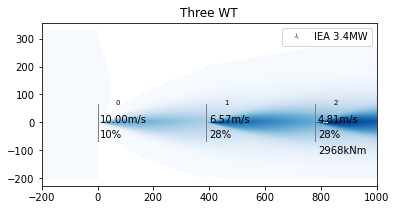

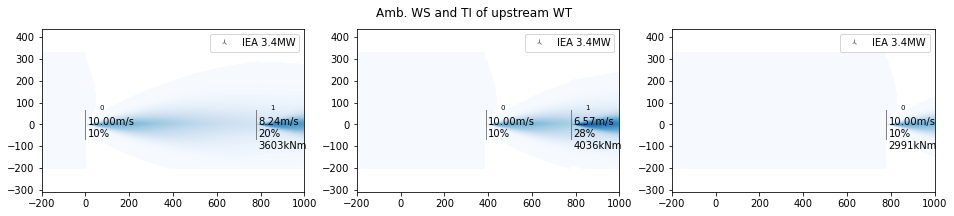

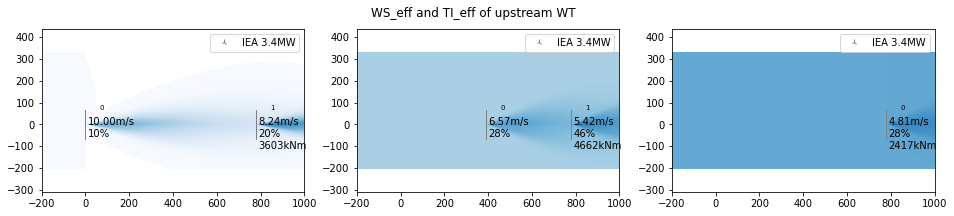

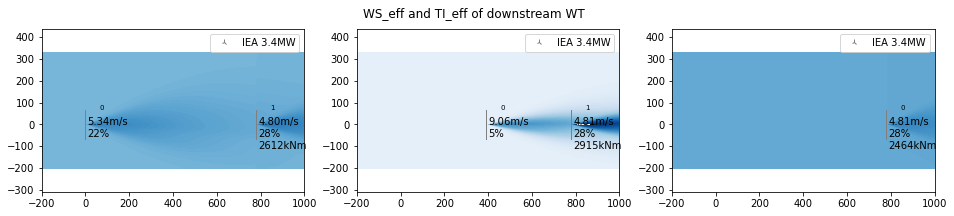

In [19]:
plot_case('A')

#### Case 2

c:\mmpe\programming\python\topfarm\pywake\py_wake\utils\tensorflow_surrogate_utils.py:109: UserWarning: Input, ti, with value, 0.6898254406022548 outside range 6.94521e-05-0.5157860142
  warnings.warn(f"Input, {k}, with value, {max_v} outside range {mi}-{ma}")
c:\mmpe\programming\python\topfarm\pywake\py_wake\utils\tensorflow_surrogate_utils.py:109: UserWarning: Input, ti, with value, 0.6898254406022548 outside range 6.94521e-05-0.5157860142
  warnings.warn(f"Input, {k}, with value, {max_v} outside range {mi}-{ma}")


sensor | wohler | HAWC2 | UW | UW_eff | DW_eff
 -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 2955|4060(+37%)|4060(+37%)|4508(+53%)
del_blade_edge | 10 | 5818|6147(+6%)|6147(+6%)|5862(+1%)
del_tower_bottom_fa | 4 | 8501|17381(+104%)|17381(+104%)|30350(+257%)
del_tower_bottom_ss | 4 | 3432|4736(+38%)|4736(+38%)|21248(+519%)
del_tower_top_torsion | 7 | 2296|3361(+46%)|3361(+46%)|3157(+38%)

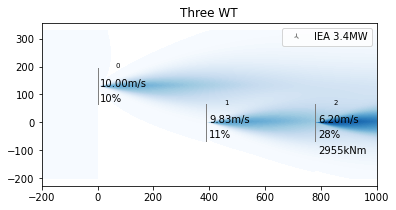

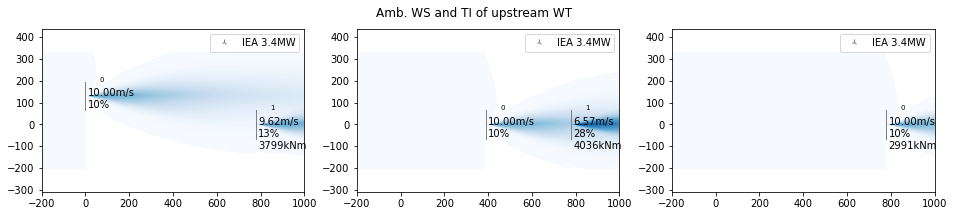

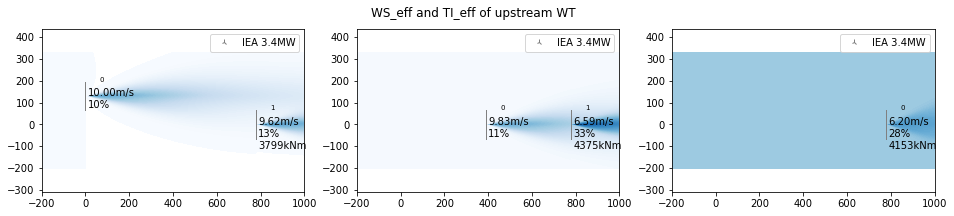

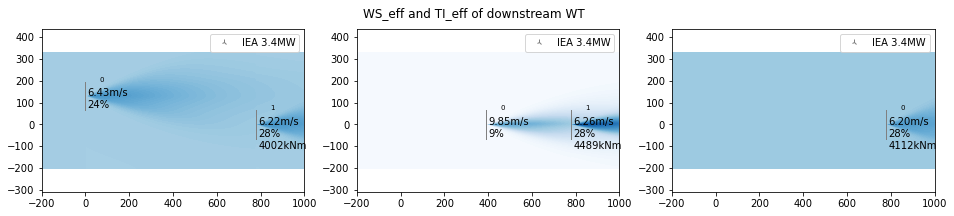

In [20]:
plot_case('B')

#### Case C

sensor | wohler | HAWC2 | UW | UW_eff | DW_eff
 -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 3015|3609(+20%)|3609(+20%)|4780(+59%)
del_blade_edge | 10 | 5916|6033(+2%)|6033(+2%)|6121(+3%)
del_tower_bottom_fa | 4 | 8946|12529(+40%)|12529(+40%)|19165(+114%)
del_tower_bottom_ss | 4 | 3576|4336(+21%)|4336(+21%)|7817(+119%)
del_tower_top_torsion | 7 | 2346|2780(+18%)|2780(+18%)|3768(+61%)

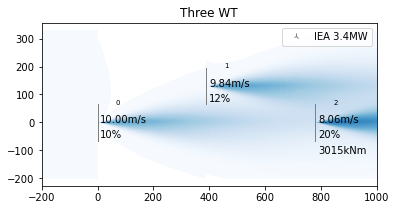

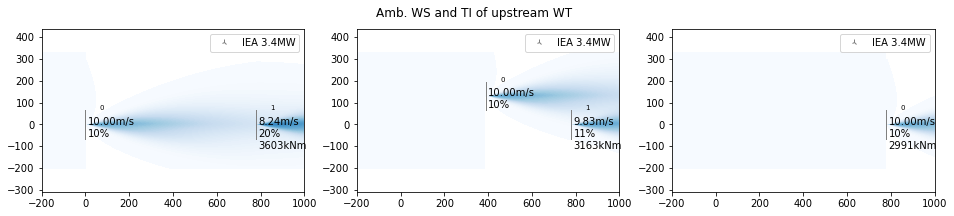

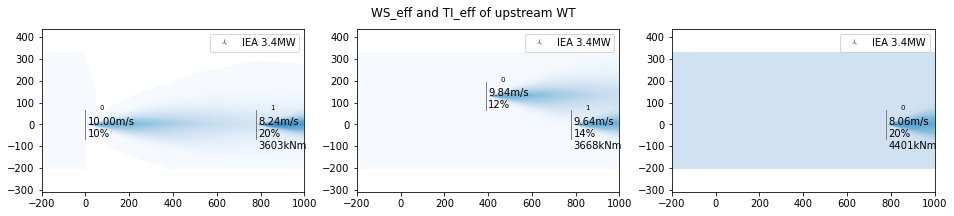

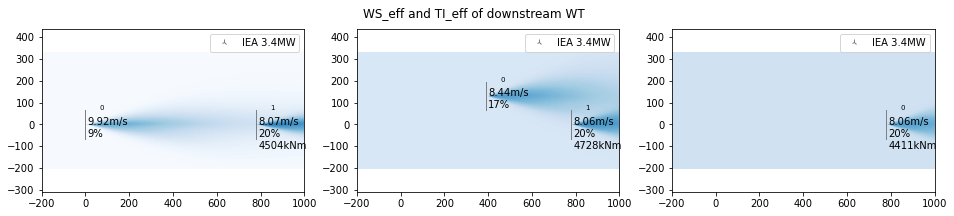

In [21]:
plot_case('C')

#### Case D

sensor | wohler | HAWC2 | UW | UW_eff | DW_eff
 -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 3015|3801(+26%)|3801(+26%)|3753(+24%)
del_blade_edge | 10 | 5920|6168(+4%)|6168(+4%)|6177(+4%)
del_tower_bottom_fa | 4 | 8961|11049(+23%)|11049(+23%)|11244(+25%)
del_tower_bottom_ss | 4 | 3527|4004(+14%)|4004(+14%)|4573(+30%)
del_tower_top_torsion | 7 | 2363|2802(+19%)|2802(+19%)|3159(+34%)

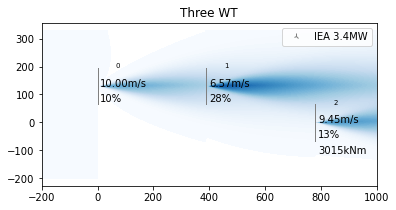

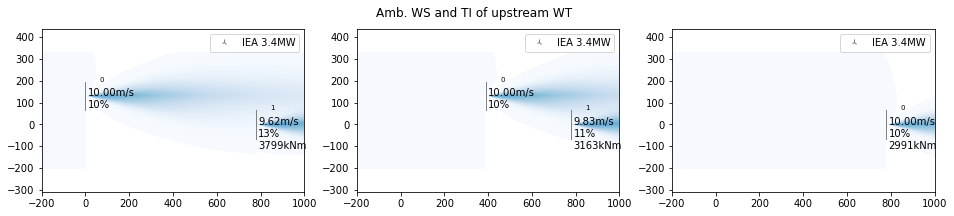

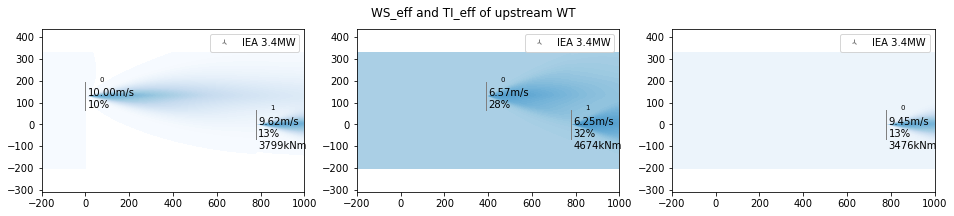

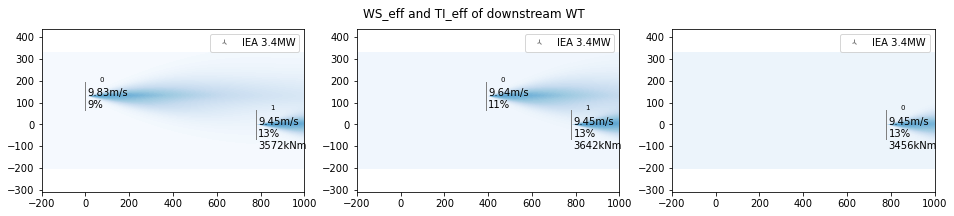

In [22]:
plot_case('D')

#### Plot D

sensor | wohler | HAWC2 | UW | UW_eff | DW_eff
 -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 3015|3801(+26%)|3801(+26%)|3753(+24%)
del_blade_edge | 10 | 5920|6168(+4%)|6168(+4%)|6177(+4%)
del_tower_bottom_fa | 4 | 8961|11049(+23%)|11049(+23%)|11244(+25%)
del_tower_bottom_ss | 4 | 3527|4004(+14%)|4004(+14%)|4573(+30%)
del_tower_top_torsion | 7 | 2363|2802(+19%)|2802(+19%)|3159(+34%)

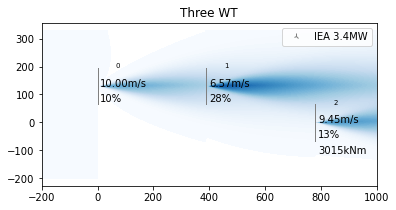

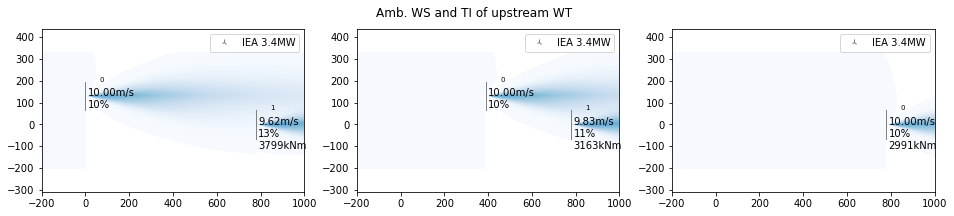

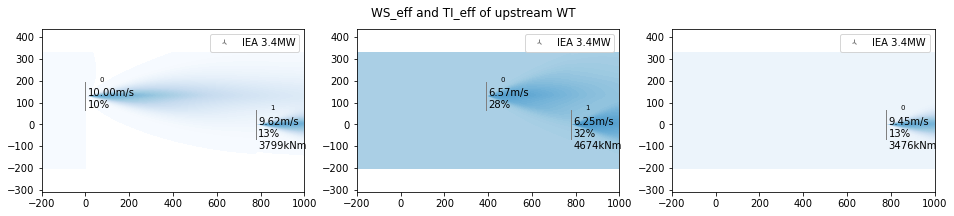

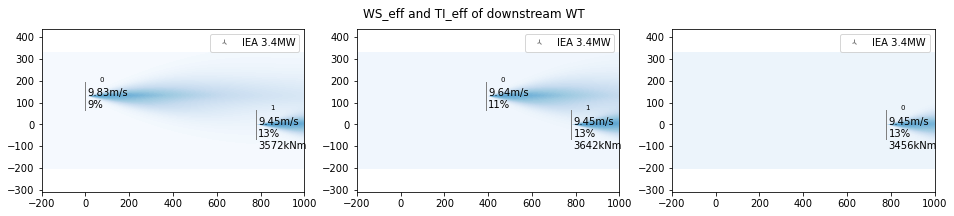

In [23]:
plot_case('D')

#### Case E

sensor | wohler | HAWC2 | UW | UW_eff | DW_eff
 -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 2900|3607(+24%)|3607(+24%)|4651(+60%)
del_blade_edge | 10 | 5733|6028(+5%)|6028(+5%)|6099(+6%)
del_tower_bottom_fa | 4 | 8158|12529(+54%)|12529(+54%)|18812(+131%)
del_tower_bottom_ss | 4 | 3325|4337(+30%)|4337(+30%)|7715(+132%)
del_tower_top_torsion | 7 | 2238|2782(+24%)|2782(+24%)|3783(+69%)

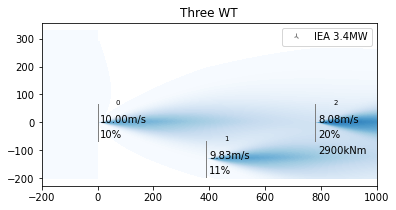

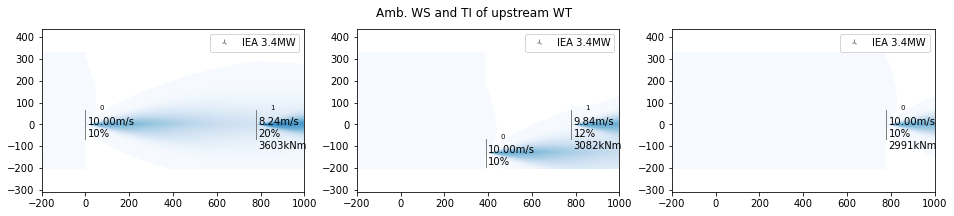

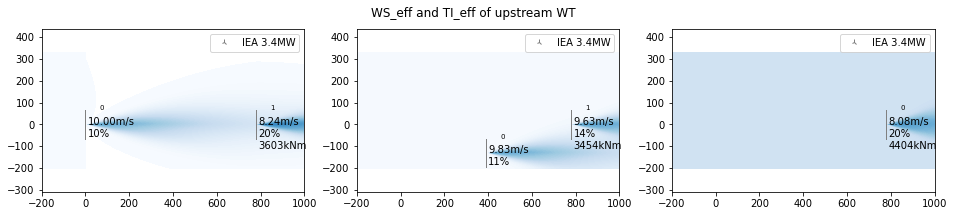

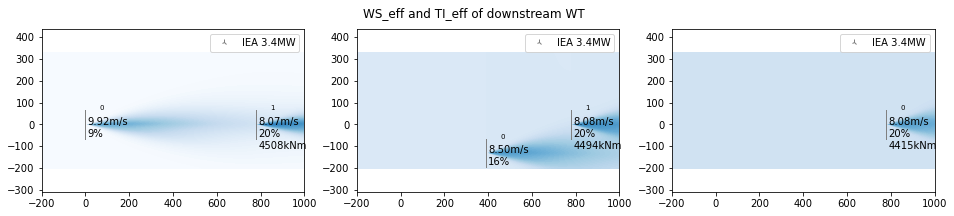

In [24]:
plot_case('E')

#### Case F

sensor | wohler | HAWC2 | UW | UW_eff | DW_eff
 -- | -- | -- | -- | -- | -- 
del_blade_flap | 10 | 2900|3596(+24%)|3596(+24%)|3821(+32%)
del_blade_edge | 10 | 5733|5995(+5%)|5995(+5%)|6044(+5%)
del_tower_bottom_fa | 4 | 8158|10670(+31%)|10670(+31%)|11582(+42%)
del_tower_bottom_ss | 4 | 3325|4198(+26%)|4198(+26%)|4907(+48%)
del_tower_top_torsion | 7 | 2238|2733(+22%)|2733(+22%)|3314(+48%)

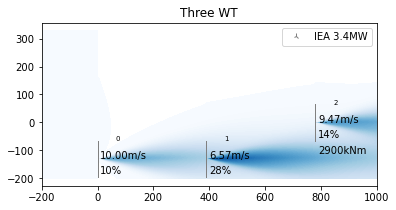

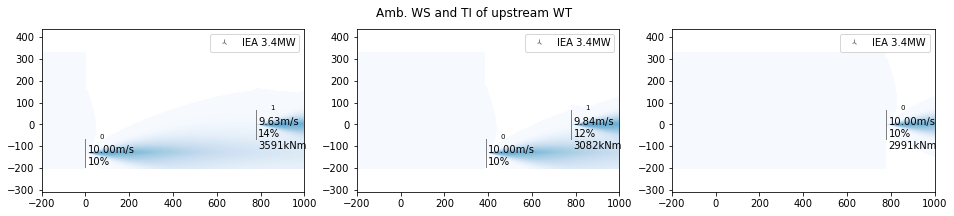

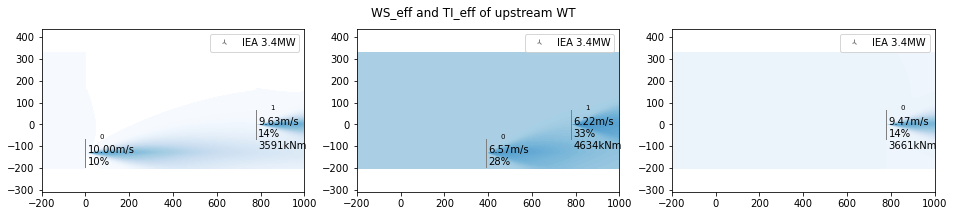

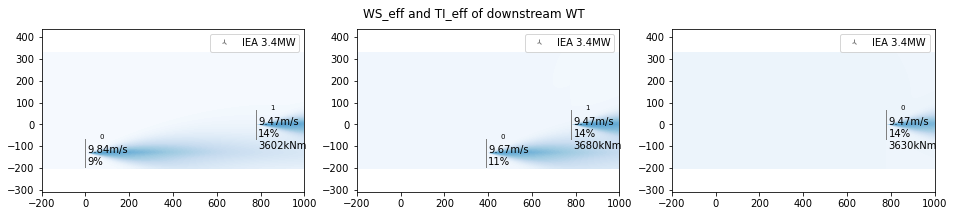

In [25]:
plot_case('F')